# Project 2 - Analyzing the NYC Subway Dataset
'''
Created by Laura Uzcategui 
Date : 30 Sept 2015 
'''


# Subway Ridership 

Subway ridership consists of all passengers (other than NYC Transit employees) who enter the subway system, including passengers who transfer from buses.  Ridership does not include passengers who exit the subway or passengers who transfer from other subway lines, with the exception of out-of-system transfers; e.g., between the Lexington Av/63 St F subwaystation and the Lexington Avenue N subwayQ subwayR subway/59 St4 subway5 subway6 subwaystation, where customers use their MetroCard to make the transfer.

This project has the purpose to analyze and investigate if more people ride the Subway when is raining vs when it is not raining. [1]

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


<function matplotlib.pyplot.show>

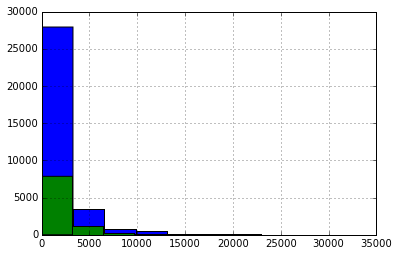

In [40]:
# making available graphs inline
%pylab inline
# importing pandas for manipulation of data
import pandas as pd
# importing matplotlib for printing the plot
import matplotlib.pyplot as plt

# Importing scipy for working with Mann-Whitney U-Test
import scipy
import scipy.stats

#Importing numpy and statsmodels for Linear Regression 
import numpy as np
import statsmodels.api as sm
import sys

# calculus for Gradient Descent
from sklearn.linear_model import SGDRegressor

from ggplot import *

# Loading the path of our NYC subway dataset
filename = './turnstile_weather_v2.csv'

# Let's read our dataset
weather_data = pd.read_csv(filename)


def entries_histogram(turnstile_weather):
      
    plt.figure()
    #Blue Bars - NO Rain
    turnstile_weather[turnstile_weather.rain==0].ENTRIESn_hourly.hist() # your code here to plot a historgram for hourly entries when it is not raining (GREEN)
    #Green Bars - Raining
    turnstile_weather[turnstile_weather.rain==1].ENTRIESn_hourly.hist() # your code here to plot a historgram for hourly entries when it is raining (BLUE)
    plt.title = "Entries when Raining vs When is not raining"
    return plt

entries_histogram(weather_data).show

Both Histograms does not seems to follow a Normal Distribution. 

##Section 1. Statistical Test 

####1.1 Which statistical test did you use to Analyze the NYC Subway data?
 
  The statistical test used for Analyze NYC Subway data is Mann Whitney U Test. 
 
#### Did you use a one-tail or a two-tail P Value ? 
  
   The P value used is Two Tail Test. 
  

#### What is the null hypothesis ? 

The appropiate hypothesis for this task will be the following: 
* H0 ( Null hypothesis) : $ P( Rain  >  No Rain ) \leqq 0.5 $ 
Probability that Riderships with Rain is larger 

* H1 ( Alternative hypothises) : $ P( Rain  >  No Rain )  \gt 0.5 $ 

#### What is your p-critical value? 

 The p-critical value will be 0.025 since is two-sided Test.
 
#### 1.2 Why is this statistical test applicable to the dataset? 
  
 Based on the visualisation for the Histograms, the distributions do not seems to be Normal and based on the assumption We draw the data from unknown distributions We could apply Mann-Whitney U Test.
 

In [41]:
def mann_whitney_plus_means(turnstile_weather):
  
    entries_rain = turnstile_weather[turnstile_weather.rain==1].ENTRIESn_hourly
    entries_norain = turnstile_weather[turnstile_weather.rain==0].ENTRIESn_hourly

    with_rain_mean = np.mean(entries_rain)
    without_rain_mean = np.mean(entries_norain)
    U, p = scipy.stats.mannwhitneyu(entries_rain,entries_norain)
    
    return with_rain_mean, without_rain_mean, U, p*2 # leave this line for the grader


In [42]:
print mann_whitney_plus_means(weather_data)

(2028.1960354720918, 1845.5394386644084, 153635120.5, 5.4821391424874991e-06)


#### 1.3 What results did you get from this statistical test ? 
 
 A Mann-Whitney  U Test indicated that Ridership when is Raining (Mean = 2028.1960354720918) was statiscally significant different than Ridership when is not Raining (Mean = 1845.5394386644084), U =153635120.5, p=5.48213e-06 
 
####1.4 What is the significance and interpretation of these results?
 We reject the null hypothesis since the results are statically significant different and it falls within the critical region

##Section 2. Linear Regression.

####2.1 What approach did you use to compute the coefficients theta and produce prediction for ENTRIESn_hourly in your regression model:
    
  The approach used for compute coefficients and prediction were : OLS and Gradient Descent
    
####2.2 What features (input variables) did you use in your model? Did you use any dummy variables as part of your features?

    hour - Hour of the timestamp from TIMEn
    rain - Indicator (0 or 1) if rain occurred within the calendar day at the location.
    fog - Indicator (0 or 1) if there was fog at the time and location.
    precipi - Precipitation in inches at the time and location.
    tempi - Temperature in ℉ at the time and location.
    wspdi - Wind speed in mph at the time and location.
    pressurei - Barometric pressure in inches Hg at the time and location.
    
    meantempi - Daily average of tempi for the location
    meanprecipi - Daily average of precipi for the location.
    meanwspdi - Daily average of wspdi for the location
    meanpressurei - Daily average of pressurei for the location.
    
    weekday - Indicator (0 or 1) if the date is a weekday (Mon ­ Fri)
    day_week - Integer (0 ­ 6 Mon ­ Sun) corresponding to the day of the week.

     
 As part of the features selected a Dummy variable has been selected. 
     UNIT  - Remote unit that collects turnstile information ( Subway station )
 

####2.3 Why did you select these features in your model? We are looking for specific reasons that lead you to believe that

 The reasons for select the features in the model were: 
    Whenever the weather is different than sunny, such as Windy (wspdi), Rainy(rain) or Foggy(fog), riders always prefer to use Subway since they don't have to drive or use bike for going to work, school or college. 
    Also, It has been selected some features such as rain and means for wind,tempeature,precipitation and pressure. And if it's a weekday on based on the day of the week the values for R squared were improved drastically.


In [43]:
def linear_regression(features, values):
    """
     Linear regression applied with OLS 
    """

    features = sm.add_constant(features)
    
    model = sm.OLS(values,features)
    results = model.fit()
    intercept = results.params[0]
    parameters = results.params[1:]
    print results.summary()
    #print parameters
    return intercept, parameters

def predictions(dataframe):
   
    features = dataframe[['hour','rain','fog','precipi','tempi','wspdi','pressurei',\
                          'meantempi','meanprecipi','meanwspdi','meanpressurei', \
                          'weekday','day_week']]
    dummy_units = pd.get_dummies(dataframe['UNIT'], prefix='unit')
    features = features.join(dummy_units)

    # Values
    values = dataframe['ENTRIESn_hourly']

    # Perform linear regression
    intercept, params = linear_regression(features, values)

    predictions = intercept + np.dot(features, params)
    return predictions



####2.4 What are the parameters (also known as "coefficients" or "weights") of the non-dummy features in your linear regression model?
 The parameters are the that minimize the least squares criterion for the model. 
 
  Please observe the table below in which the coeffiecients of the non-dummy features can be appreciated.


In [44]:
pred =  predictions(weather_data)


                            OLS Regression Results                            
Dep. Variable:        ENTRIESn_hourly   R-squared:                       0.489
Model:                            OLS   Adj. R-squared:                  0.486
Method:                 Least Squares   F-statistic:                     161.1
Date:                Wed, 14 Oct 2015   Prob (F-statistic):               0.00
Time:                        23:12:51   Log-Likelihood:            -3.8697e+05
No. Observations:               42649   AIC:                         7.744e+05
Df Residuals:                   42396   BIC:                         7.766e+05
Df Model:                         252                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
const          1.367e+04   2609.729      5.237

In [45]:
def compute_r_squared(data, predictions):
    '''data - refers to data points collected
       predictions - based on features selected we calculate 
    '''
    mean_p = np.mean(data) # mean of observations
    sse = np.sum((data-predictions)**2) #sum squared error
    sst = np.sum((data-mean_p)**2) # total sum of squares

    r_squared = 1 - ( sse / sst )
    #print data.shape
    #print predictions.shape
    
    return r_squared

In [46]:
dataPoints = weather_data['ENTRIESn_hourly']
r_squared = compute_r_squared(dataPoints,pred)
print "R-squared = ",r_squared

R-squared =  0.489231502009


####2.5 What is your model’s R2 (coefficients of determination) value?
$ R^2$  = 0.48923

####2.6 What does this R2 value mean for the goodness of fit for your regression model? Do you think this linear model to predict ridership is appropriate for this dataset, given this R2  value?

This value seem like a good fit for the model since is superior to 0.40 and closer to 1.

Let's take a look trough plotting some residuals for the model. Which looks like a normal distribution with mean = 0 and by having a peek that might indicated us to do further transformations to the dataset and check if the regression behaved slighlty better and of course have a better prediction.

In [47]:
def plot_residuals(turnstile_weather, predictions):
    plt.figure()
    (turnstile_weather['EXITSn_hourly'] - predictions).hist(bins=80)
    return plt

<module 'matplotlib.pyplot' from '/home/laura/.local/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>


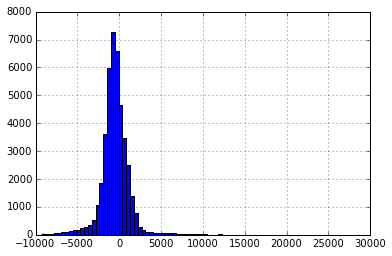

In [48]:
print plot_residuals(weather_data,pred)

### Additional ( Linear regression with Gradient Descent ) 

For exploration of another ways to make the predictions, Linear regression Gradient descent has been applied. 

In [49]:
def normalize_features(features):
    '''
    Returns the means and standard deviations of the given features, along with a normalized feature
    matrix.
    '''
    means = np.mean(features, axis=0)
    std_devs = np.std(features, axis=0)
    normalized_features = (features - means) / std_devs
    return means, std_devs, normalized_features

def recover_params(means, std_devs, norm_intercept, norm_params):
    '''
    Recovers the weights for a linear model given parameters that were fitted using
    normalized features. Takes the means and standard deviations of the original
    features, along with the intercept and parameters computed using the normalized
    features, and returns the intercept and parameters that correspond to the original
    features.
    '''
    intercept = norm_intercept - np.sum(means * norm_params / std_devs)
    params = norm_params / std_devs
    return intercept, params

def linear_regression(features, values):
    """
    Perform linear regression given a data set with an arbitrary number of features.
    """
    clf = SGDRegressor(n_iter=1500)
    clf.fit(features, values)
    intercept = clf.intercept_
    params = clf.coef_
 
    return intercept, params

def predictions(dataframe):
    '''
    Let's predict the ridership of cthe NYC subway using linear regression with gradient descent.
    '''
    
    features =  dataframe[['hour','rain','fog','precipi','tempi','wspdi','pressurei',\
                          'meantempi','meanprecipi','meanwspdi','meanpressurei', \
                          'weekday','day_week']]
    
    dummy_units = pd.get_dummies(dataframe['UNIT'], prefix='unit')
    features = features.join(dummy_units)

    # Values
    values = dataframe['ENTRIESn_hourly']

    # Get numpy arrays
    features_array = features.values
    values_array = values.values

    means, std_devs, normalized_features_array = normalize_features(features_array)

    # Perform gradient descent
    norm_intercept, norm_params = linear_regression(normalized_features_array, values_array)

    intercept, params = recover_params(means, std_devs, norm_intercept, norm_params)

    predictions = intercept + np.dot(features_array, params)

    return predictions


In [50]:
#get predictions from gradient descent 
pred_gd = predictions(weather_data)

#calculate r-squared for Gradient descent predictions 
r_squared = compute_r_squared(dataPoints,pred_gd)
print "R-squared = ",r_squared


R-squared =  0.483483010174


##Section 3. Visualization




In [57]:
def entries_histogram_rain(turnstile_weather):
    
    r_plot = ggplot(aes(x='ENTRIESn_hourly'), turnstile_weather) + geom_histogram(binwidth=1000, colour = "black",\
                                                                                  fill="blue")
    return r_plot

weather_rain = weather_data[weather_data.rain == 1]


### Histogram of Entries by Hour

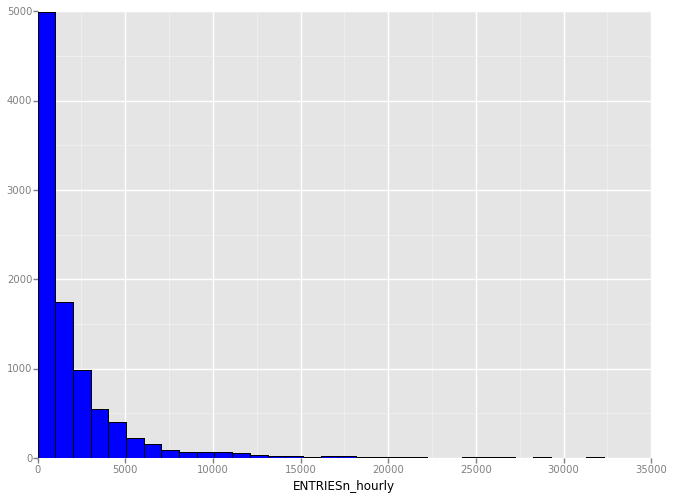

<ggplot: (8757024142917)>


In [58]:
print entries_histogram_rain(weather_rain)

In [61]:
def entries_histogram_Norain(turnstile_weather):
      
    r_plot = ggplot(aes(x='ENTRIESn_hourly'), turnstile_weather) + \
    geom_histogram(binwidth=1000,colour = "black", fill="green" )
    return r_plot

weather_Norain = weather_data[weather_data.rain == 0]


### Histogram of Entries by Hour

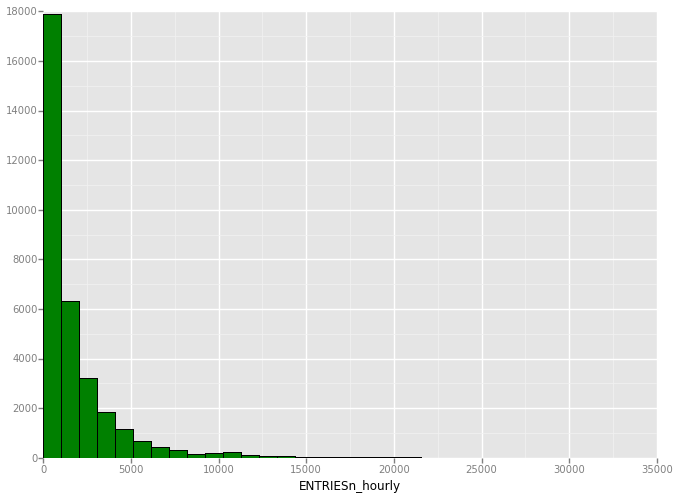

<ggplot: (8757013762617)>


In [62]:
print entries_histogram_Norain(weather_Norain)

In [63]:
def plot_weather_data(turnstile_weather):

    pd.options.mode.chained_assignment = None

    g = turnstile_weather.groupby(['hour','day_week']).sum().reset_index()
    pplot = ggplot(g, aes('hour', 'ENTRIESn_hourly', color='day_week')) + geom_point() + geom_line()
    return pplot




### Visualisation of Ridership by Hour and Day of Week.

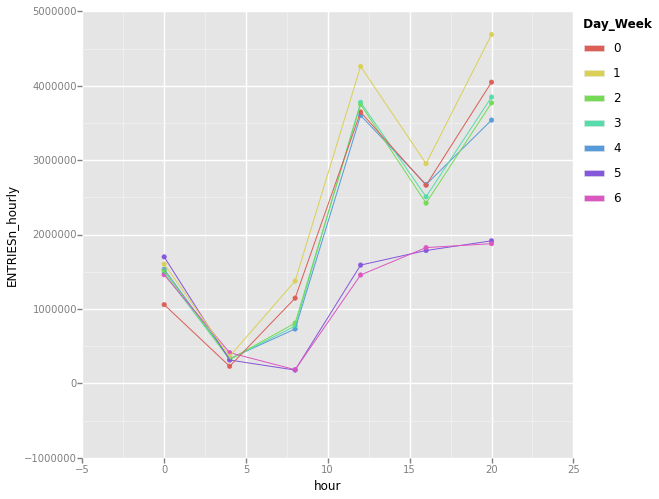

<ggplot: (8757013762621)>


In [64]:
print plot_weather_data(weather_data)

## Section 4. Conclusion

####4.1 From your analysis and interpretation of the data, do more people ride the NYC subway when it is raining or when it is not raining?  

 Based on the analysis and interpretation of the data, more people ride the NYC when is not raining. 

####4.2 What analyses lead you to this conclusion? You should use results from both your statistical tests and your linear regression to support your analysis.

 Once the statistical test has been done, the rejection of the null hypothesis led us to confirm that the probability of Rain vs NoRain could be higher than 50% but might be presence of outliars so that We proceeded to execute linnear regresion by choosing features such as the ones related with the weather (fog,wind,rain and pressure) also the means for every of this features. 
 
 After the execution of linear regression for least squares and gradient descent and with the $R^2$ of 0.48 obtained plus the chart for the residuals we can determined that the model for the prediction is a good fit since the mean is around cero. 
 

## Section 5. Reflection

####5.1 Please discuss potential shortcomings of the methods of your analysis, including:
    Dataset: the dataset could be improved by wrangling the data for values such as day_week and filling or excluding empty values for rows were weigths were bigger. 
    Analysis: this project has been analysed carefully, nevertheless it could be improved by checking and adjusting multiple combinations of features.
####5.2 (Optional) Do you have any other insight about the dataset that you would like to share with us?

The dataset shared was understandble,  but I believe it could be better if from the beginning students will manipulated the improved dataset.